In [106]:
%reset
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from trainer.segnet import build_encoder_decoder, build_refinement
from trainer.test_model import build_test_encoder_decoder, build_test_refinement
from trainer.utils import get_final_output
from trainer.data_generator import composite4

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [207]:
img_rows, img_cols = 320, 320
channel = 3
checkpoint = '/Users/erez/Desktop/deep_image_matting_20190429_115043_checkpoints_checkpoint.26-0.1750.hdf5'
#checkpoint = '../models/final.42-0.0398.hdf5'

#imageName = "0cdf5b5d0ce1_05"
imageName = "26ccab021981_07"

bg = cv.imread('/Users/erez/Desktop/data/test/background_test/1891.jpg')
fg = cv.imread('/Users/erez/Desktop/data/test/carvana/' + imageName + '.jpg')
gt = cv.imread('/Users/erez/Desktop/data/test/carvana/' + imageName + '_mask.jpg' ,0)

In [208]:
encoder_decoder = build_encoder_decoder()
final = build_refinement(encoder_decoder)
final.load_weights(checkpoint)
#print(final.summary())

In [209]:
x_test = np.empty((1, img_rows, img_cols, channel), dtype=np.float32)

if fg.shape[0] != 320: 
    fg = cv.resize(fg, (img_rows, img_cols))
    gt = cv.resize(gt, (img_rows, img_cols))
    
    
x_test[0, :, :, 0:3] = fg / 255.
#try testing with a composite instead of the original image: 
#x_test[0, :, :, 0:3] = composite(fg, bg, gt, 320, 320) / 255.

if channel > 3:
    trimap = generate_trimap(cv.imread(mask_path,0))
    if trimap.shape[0] != 320: 
        trimap = cv.resize(trimap, (img_rows, img_cols))
    x_test[0, :, :, 3] = trimap / 255.

In [210]:
out = final.predict(x_test)
out = np.reshape(out, (img_rows, img_cols))

out = out * 255.0

if channel > 3: 
    out = get_final_output(out, trimap)
out = out.astype(np.uint8)

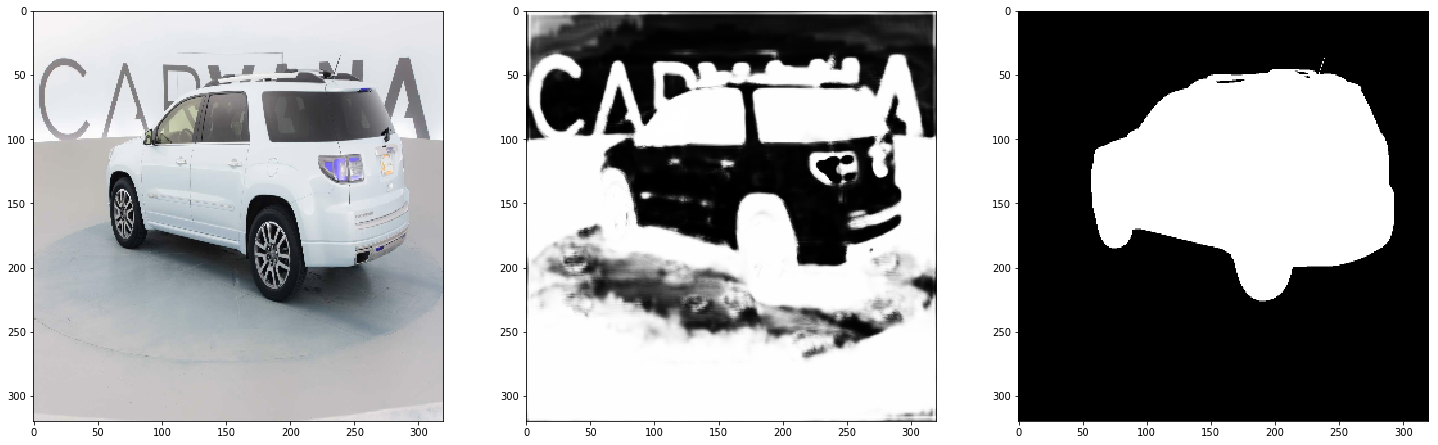

In [211]:
f, ax = plt.subplots(1,3,figsize=(25,25))

ax[0].imshow(fg )
ax[1].imshow(out, cmap = 'gray')
ax[2].imshow(gt, cmap = 'gray')

In [6]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
def generate_trimap(alpha):
    fg = np.array(np.equal(alpha, 255).astype(np.float32))
    # fg = cv.erode(fg, kernel, iterations=np.random.randint(1, 3))
    unknown = np.array(np.not_equal(alpha, 0).astype(np.float32))
    unknown = cv.dilate(unknown, kernel, iterations=np.random.randint(1, 20))
    trimap = fg * 255 + (unknown - fg) * 128
    return trimap.astype(np.uint8)


In [119]:
def composite(fg, bg, a, w, h):
    fg = np.array(fg, np.float32)
    bg_h, bg_w = bg.shape[:2]
    x = 0
    if bg_w > w:
        x = np.random.randint(0, bg_w - w)
    y = 0
    if bg_h > h:
        y = np.random.randint(0, bg_h - h)
    bg = np.array(bg[y:y + h, x:x + w], np.float32)
    alpha = np.zeros((h, w, 1), np.float32)
    alpha[:, :, 0] = a / 255.
    im = alpha * fg + (1 - alpha) * bg
    im = im.astype(np.uint8)
    return im

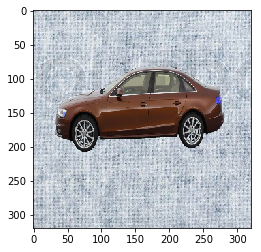